In [3]:
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [17]:
## ROI pooled embeddings (7x7x256)

In [3]:
with open('classwise_GTfeatures.pkl', 'rb') as f:
        embed_classwise = pickle.load(f)

In [12]:
embed_classwise = {}
fea_path = "/home/vaibhav/Desktop/stud/datasets/esmart/bigdetect_features/finetune/pooled/"

In [13]:
for im in os.listdir(fea_path):
    x = {}
    with open(os.path.join(fea_path,im), 'rb') as f:
        x = pickle.load(f)
        
    idx = 0
    for i in x['preds']:
        if embed_classwise.get(i.item()) == None:
            embed_classwise[i.item()] = [x['features'][idx].detach().cpu().numpy()]
        else:
            embed_classwise[i.item()].append(x['features'][idx].detach().cpu().numpy())
        idx += 1

In [14]:
# Extract embeddings and corresponding class labels
all_embeddings = []
class_labels = []
for class_label, embeddings in embed_classwise.items():
    all_embeddings.extend(embeddings)
    class_labels.extend([class_label] * len(embeddings))

# Convert to numpy arrays
all_embeddings = np.array(all_embeddings)
class_labels = np.array(class_labels)
num_sample = class_labels.shape[0]
all_embeddings = all_embeddings.reshape(num_sample,-1)

del embed_classwise

In [15]:
all_embeddings.shape,class_labels.shape

((86828, 1024), (86828,))

In [16]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=50)  # Adjust the number of components as needed
pca_embeddings = pca.fit_transform(all_embeddings)

# Compute t-SNE embeddings on PCA embeddings
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_embeddings = tsne.fit_transform(pca_embeddings)

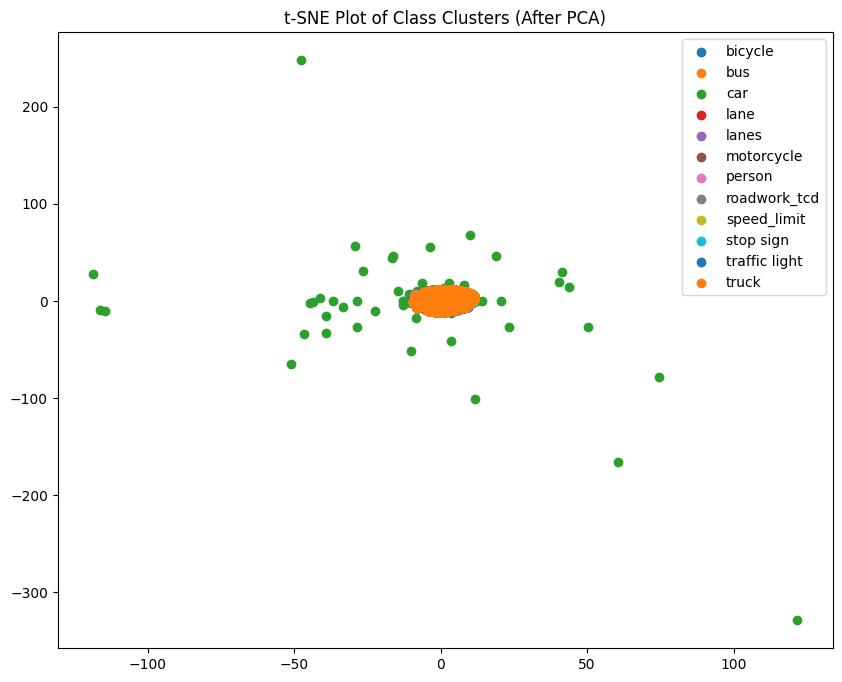

In [17]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
unique_labels = np.unique(class_labels)
for label in unique_labels:
    indices = np.where(class_labels == label)
    plt.scatter(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1], label=label)

plt.title('t-SNE Plot of Class Clusters (After PCA)')
plt.legend([
                        "bicycle","bus","car","lane","lanes","motorcycle","person",
                        "roadwork_tcd","speed_limit","stop sign", "traffic light",
                        "truck"
                          ])
plt.show()

## Train linear SVM to as measure of seperability

In [18]:
from sklearn import svm

In [19]:
#del all_embeddings
#pca_embeddings.shape

In [20]:
clf = svm.LinearSVC()
clf.fit(all_embeddings, class_labels)

/home/vaibhav/Desktop/detectron2/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [22]:
y_pred = clf.predict(all_embeddings)
y = class_labels

# Calculate and display training metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

print("Training Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Training Metrics:
Accuracy: 0.69
Precision: 0.69
Recall: 0.69
F1-score: 0.67


In [8]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
import cv2
from detectron2.data.datasets import register_coco_instances

In [14]:
#register dataset
def register_esmart_wip(root = "/home/vaibhav/Desktop/stud/datasets/esmart/"):
        things_classes = [str(i) for i in range(600)]
        name = 'esmart_wip_mod'
        metadata = {"thing_classes":things_classes}
        register_coco_instances(
                        name,
                        metadata,
                        os.path.join(root, 'labels_mod.json'),
                        os.path.join(root, 'data/'),
                    )

register_esmart_wip()

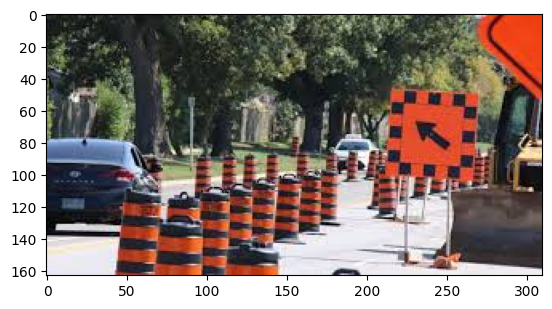

In [25]:
im = cv2.imread("/home/vaibhav/Desktop/stud/datasets/esmart/test/3.jpeg")
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [32]:
#cfg = get_cfg()
#cfg.merge_from_file("/home/vaibhav/Desktop/ood_distance/finetune_coco_trained.yaml")
# Create predictor
#cfg.MODEL.WEIGHTS = "/home/vaibhav/Desktop/ood_distance/checkpoints/esmart/coco_finetune_on_esmart/model_final.pt#h"
cfg = model_zoo.get_config(config_path="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",trained=True)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 600
cfg.DATASETS.TRAIN = ('esmart_wip_mod',)
cfg.MODEL.WEIGHTS = "/home/vaibhav/Desktop/ood_distance/checkpoints/faster_rcnn_r50_fpn_bigdet_8x.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST: 0.7
predictor = DefaultPredictor(cfg)

# Make prediction
outputs = predictor(im)

In [33]:
outputs

{'instances': Instances(num_instances=53, image_height=163, image_width=310, fields=[pred_boxes: Boxes(tensor([[1.8438e-01, 7.6286e+01, 7.0491e+01, 1.3726e+02],
         [1.7932e+02, 7.5935e+01, 2.0738e+02, 1.0057e+02],
         [6.8384e+01, 1.3020e+02, 9.8160e+01, 1.6300e+02],
         [8.8482e+01, 5.0138e+01, 9.4131e+01, 1.0119e+02],
         [1.7768e+02, 7.6351e+01, 2.0713e+02, 1.0015e+02],
         [1.2822e+02, 1.0249e+02, 1.4431e+02, 1.4507e+02],
         [1.8760e+02, 8.6294e+01, 1.9577e+02, 1.0348e+02],
         [0.0000e+00, 7.7038e+01, 7.2259e+01, 1.3475e+02],
         [2.8781e+02, 8.0728e+01, 3.0934e+02, 1.1138e+02],
         [4.3105e-01, 7.6761e+01, 7.2289e+01, 1.3905e+02],
         [9.5245e+01, 1.0785e+02, 1.1543e+02, 1.6300e+02],
         [1.2818e+02, 1.0258e+02, 1.4432e+02, 1.4529e+02],
         [1.7815e+02, 1.5843e+02, 1.9703e+02, 1.6300e+02],
         [1.2827e+02, 1.0193e+02, 1.4395e+02, 1.4620e+02],
         [2.0654e+02, 1.0071e+02, 2.2060e+02, 1.2667e+02],
         [6.1

In [30]:
cfg.DATASETS.TRAIN

('esmart_wip_mod',)

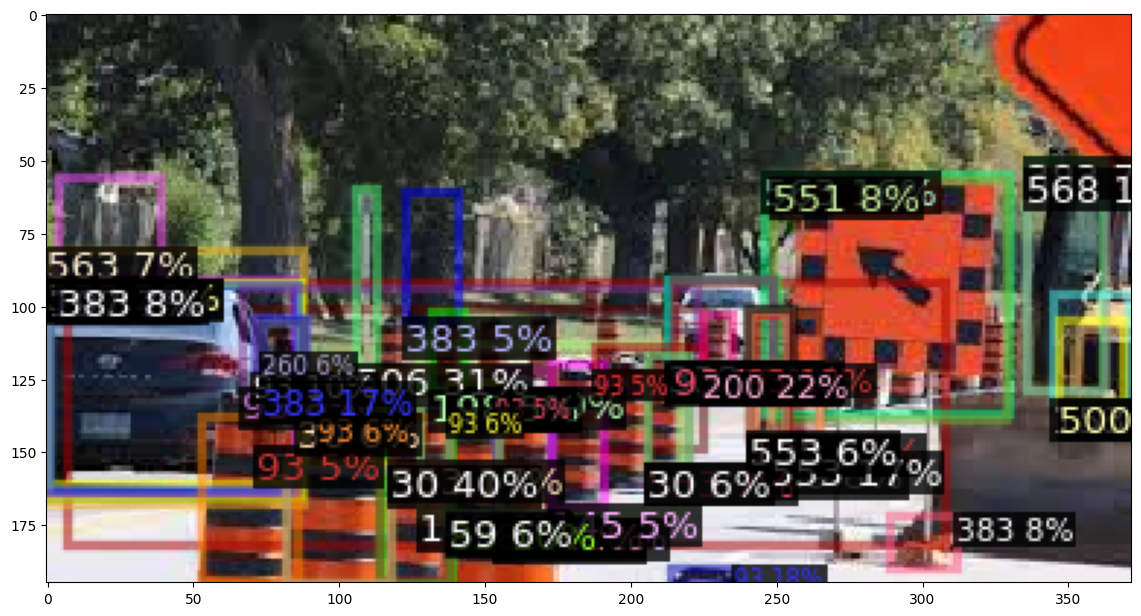

In [34]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

## Penultimate layer of COCO trained FRCNN-FPN, using GT boxes in ROI pooling (1024)

In [4]:
embed_classwise = {}    
fea_path = "/home/vaibhav/Desktop/stud/datasets/esmart/GTfeatures/pooled"

In [5]:
for im in os.listdir(fea_path):
    x = {}
    with open(os.path.join(fea_path,im), 'rb') as f:
        x = pickle.load(f)
    idx = 0
    for i in x['preds']:
        if embed_classwise.get(i.item()) == None:
            embed_classwise[i.item()] = [x['features'][idx].detach().cpu().numpy()]
        else:
            embed_classwise[i.item()].append(x['features'][idx].detach().cpu().numpy())
        idx += 1

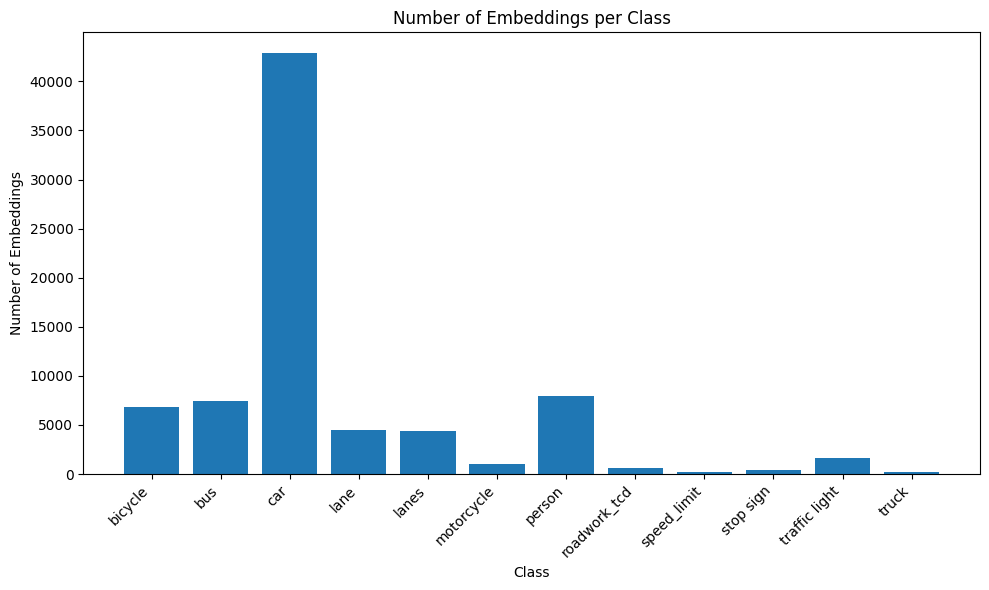

In [13]:
class_counts = {class_label: len(embeddings) for class_label, embeddings in embed_classwise.items()}

# Create a bar plot
plt.figure(figsize=(10, 6))
classes = [
                        "bicycle","bus","car","lane","lanes","motorcycle","person",
                        "roadwork_tcd","speed_limit","stop sign", "traffic light",
                        "truck"
                          ]
plt.bar(classes, class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Embeddings')
plt.title('Number of Embeddings per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [6]:
# Extract embeddings and corresponding class labels
all_embeddings = []
class_labels = []
for class_label, embeddings in embed_classwise.items():
    all_embeddings.extend(embeddings)
    class_labels.extend([class_label] * len(embeddings))

# Convert to numpy arrays
all_embeddings = np.array(all_embeddings)
class_labels = np.array(class_labels)
num_sample = class_labels.shape[0]
all_embeddings = all_embeddings.reshape(num_sample,-1)

del embed_classwise


In [ ]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=50)  # Adjust the number of components as needed
pca_embeddings = pca.fit_transform(all_embeddings)

# Compute t-SNE embeddings on PCA embeddings
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_embeddings = tsne.fit_transform(pca_embeddings)

In [7]:
all_embeddings.shape,class_labels.shape

((78042, 1024), (78042,))

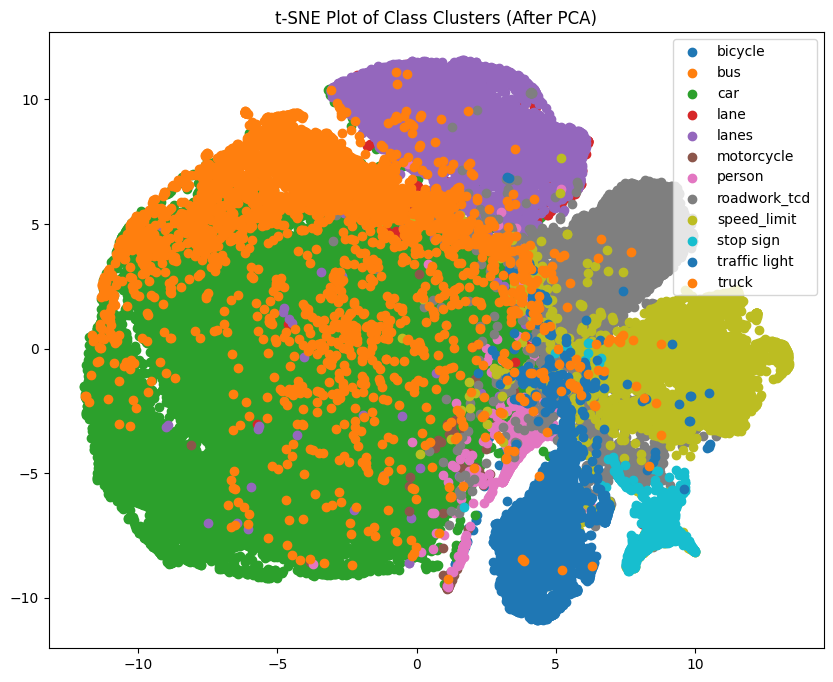

In [12]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
unique_labels = np.unique(class_labels)
for label in unique_labels:
    indices = np.where(class_labels == label)
    plt.scatter(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1], label=label)

plt.title('t-SNE Plot of Class Clusters (After PCA)')
plt.legend([
                        "bicycle","bus","car","lane","lanes","motorcycle","person",
                        "roadwork_tcd","speed_limit","stop sign", "traffic light",
                        "truck"
                          ])
plt.show()

## Train linear SVM to as measure of seperability

In [8]:
from sklearn import svm

In [9]:
clf = svm.LinearSVC()
clf.fit(all_embeddings, class_labels)

/home/vaibhav/Desktop/detectron2/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [14]:
y_pred = clf.predict(all_embeddings)
y = class_labels

# Calculate and display training metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

print("Training Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Training Metrics:
Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1-score: 0.97


In [15]:
y_pred

array([8, 8, 8, ..., 0, 0, 0])